<a href="https://colab.research.google.com/github/AnandShegde/pml_baselines/blob/main/CoinTossProblem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [120]:
try:
  import pystan
except:
  %pip install -qq pystan
  import pystan
import tensorflow as tf
import seaborn as sns
import numpy as np
import jax
import jax.numpy as jnp
!pip install tensorflow_probability
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import arviz as az

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [84]:
bern = tfd.Bernoulli(0.8)

In [85]:
key = jax.random.PRNGKey(10)
samples = bern.sample(seed = key,sample_shape=10)

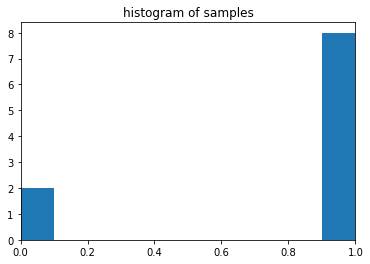

In [86]:
plt.hist(samples)
plt.xlim(0,1)
plt.title("histogram of samples")
plt.show()

In [87]:
stan_bernoulli = """
data {
  int<lower=0> n;
  int<lower=0, upper=1> heads[n];
  real alpha0;
  real beta0;
}
parameters {
  real<lower=0, upper=1> theta;
}
model {
  heads ~ bernoulli(theta);
  theta ~ beta(alpha0, beta0);
}
"""

#**Using HMC(Hamiltonian Monte Carlo)**

In [88]:
model_bernoulli = pystan.StanModel(model_code=stan_bernoulli)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_18bdecd784a575468a8abc566d68f410 NOW.


In [91]:
coin_data = {
    'n':     10,
    'heads': samples,
    'alpha0':     10,
    'beta0':     15
}

In [92]:
model_bernoulli_hmc = model_bernoulli.sampling(data=coin_data, chains=8, warmup=500, iter=1500)

In [93]:
model_bernoulli_hmc

Inference for Stan model: anon_model_18bdecd784a575468a8abc566d68f410.
8 chains, each with iter=1500; warmup=500; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=8000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta   0.51  1.5e-3   0.08   0.35   0.46   0.51   0.57   0.68   3016    1.0
lp__  -24.77    0.01   0.73 -26.81 -24.96 -24.48  -24.3 -24.25   2867    1.0

Samples were drawn using NUTS at Tue May 31 12:06:54 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [94]:
theta_hmc=(model_bernoulli_hmc.extract())['theta'].mean()
theta_hmc

0.5122766884301145

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc2b5a5f210>,
      dtype=object)

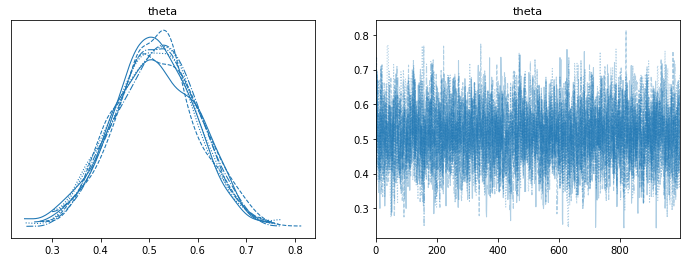

In [95]:
az.plot_trace(model_bernoulli_hmc, figsize = (12, 4))

In [123]:
bernoullihmc_df = model_bernoulli_hmc.to_dataframe()
bernoullihmc_df

,chain,draw,warmup,theta,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__
0,0,0,0,0.365381,-25.853074,0.798792,1.082021,1,1,0,25.857744
1,0,1,0,0.379669,-25.549730,1.000000,1.082021,2,3,0,26.002604
2,0,2,0,0.409363,-25.028170,1.000000,1.082021,1,1,0,25.507027
3,0,3,0,0.619125,-25.039897,0.999780,1.082021,2,7,0,25.040508
4,0,4,0,0.668819,-26.026893,0.937136,1.082021,2,3,0,26.048062
...,...,...,...,...,...,...,...,...,...,...,...
7995,7,995,0,0.553750,-24.355648,0.970001,1.124815,2,3,0,24.428205
7996,7,996,0,0.576441,-24.519942,0.953875,1.124815,1,1,0,24.530423
7997,7,997,0,0.569780,-24.463888,1.000000,1.124815,1,1,0,24.556076
7998,7,998,0,0.601669,-24.792878,0.815795,1.124815,2,3,0,25.747475


# **Using Variational Inference(VI)**

In [96]:
model_bernoulli_vi=model_bernoulli.vb(data=coin_data)

In [ ]:
# model_bernoulli_vi

In [97]:
theta_vi=model_bernoulli_vi.get('mean_pars')
theta_vi

[0.5156474358695289]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc2b5a9a690>,
      dtype=object)

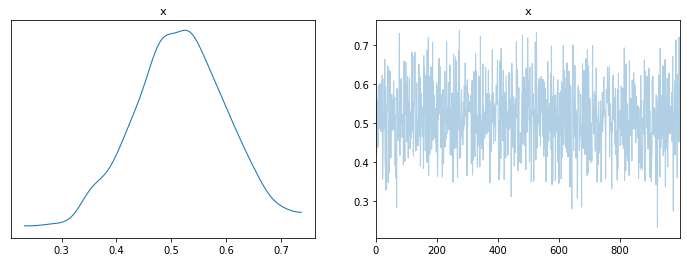

In [98]:
az.plot_trace(data=np.array(model_bernoulli_vi.get('sampler_params')[0]), figsize = (12, 4))

In [131]:
theta_vi=np.array(model_bernoulli_vi.get('sampler_params')[0])

#**Plotting the distributions**


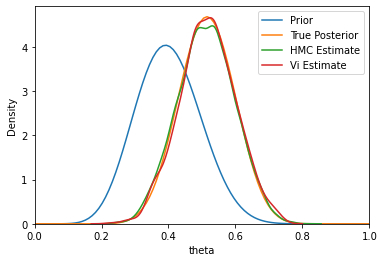

In [132]:
alpha0=10
beta0=15
beta_dist = tfd.Beta(alpha0,beta0)
x = jnp.linspace(0,1,100)
beta_pdf = beta_dist.prob(x)
plt.plot(x,beta_pdf,label="Prior")

one= jnp.sum(samples==1).astype('float32')
zero= jnp.sum(samples==0).astype('float32')
beta_dist = tfd.Beta(alpha0+one,beta0+zero)
post_pdf = beta_dist.prob(x)
plt.plot(x,post_pdf,label="True Posterior")

theta_hmc = bernoullihmc_df['theta']
sns.kdeplot(theta_hmc,label="HMC Estimate")
sns.kdeplot(theta_vi,label="Vi Estimate")
plt.legend()
plt.xlim(0,1)
plt.show()